In [1]:
!pip install -q hazm

In [2]:
!pip install -q clean-text[gpl]
!pip install transformers

# بخش اول
در بخش اول توزیع داده ها را بررسی کرده و سپس پیش پردازش های مورد نیاز را نام ببرید. در ادامه ، این
پیشپردازش ها را بر روی دادهها اعمال کرده و خروجی چند نمونه از اعمال این پیش پردازش ها را نشان دهید .


فراخوانی تابع های لازم

In [3]:
# Import required packages
import os, re,json, copy, collections,hazm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from transformers import AutoTokenizer
from cleantext import clean
import plotly.express as px
import plotly.graph_objects as go
from tqdm.notebook import tqdm

خواندن دیتا ها و یکی کردنشان برای این که تمیزکاری فقط یک بار انجام شود برای همه داده ها

In [4]:
train_data = pd.read_csv('train.csv', encoding='utf-8')
test_data = pd.read_csv('test.csv', encoding='utf-8')

# Add a column to indicate whether a row is from the training or test set
train_data['set'] = 'train'
test_data['set'] = 'test'

# Concatenate the DataFrames
data = pd.concat([train_data, test_data], ignore_index=True)

# Display the combined data
data = data[['comment', 'sentiment']]

data.head()

,comment,sentiment
0,سلام صبح بخیر ممنون از بر نامه بی نظیرتون لیلا...,1
1,همشون عالی میخوانند و چهره برتر هستند,1
2,LINK نباشید با برنامه بسیار بسیار LINK خدا زود...,0
3,حامد همایون ۶,0
4,تسلیت برای ایران و ایرانی کلمه بسیار کوچک است ...,-1


در این بخش داده های ازدست رفته را میشماریم  

In [5]:
# print data information
print('data information')
print(data.info(), '\n')

# print missing values information
print('missing values stats')
print(data.isnull().sum(), '\n')

# print some missing values
print('some missing values')
print(data[data['sentiment'].isnull()].iloc[:5], '\n')

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8512 entries, 0 to 8511
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   comment    8512 non-null   object
 1   sentiment  8512 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 133.1+ KB
None 

missing values stats
comment      0
sentiment    0
dtype: int64 

some missing values
Empty DataFrame
Columns: [comment, sentiment]
Index: [] 



* برخی از تضادها با ساختار مجموعه داده را مدیریت می کند
* من فقط اینجا ترکیب های بد را حذف می کنم
* که چون در بخش قبل متغیر از دست رفته نداشتیم  تخیری حاصل نمسشود

In [6]:

# handle some conflicts with the dataset structure
# remove these bad combinations
data['sentiment'] = data['sentiment'].apply(lambda r: r if r < 6 else None)

data = data.dropna(subset=['sentiment'])
data = data.dropna(subset=['comment'])
data = data.drop_duplicates(subset=['comment'], keep='first')
data = data.reset_index(drop=True)


# previous information after solving the conflicts

# print data information
print('data information')
print(data.info(), '\n')

# print missing values information
print('missing values stats')
print(data.isnull().sum(), '\n')

# print some missing values
print('some missing values')
print(data[data['sentiment'].isnull()].iloc[:5], '\n')

data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8502 entries, 0 to 8501
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   comment    8502 non-null   object
 1   sentiment  8502 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 133.0+ KB
None 

missing values stats
comment      0
sentiment    0
dtype: int64 

some missing values
Empty DataFrame
Columns: [comment, sentiment]
Index: [] 



*  تابع برای حساب طول جمله به تعداد کلمات


In [7]:
data['comment_len_by_words'] = data['comment'].apply(lambda t: len(hazm.word_tokenize(t)))
min_max_len = data["comment_len_by_words"].min(), data["comment_len_by_words"].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 1 	Max: 461


ین تابع به شما امکان می‌دهد تعداد مواردی را که طول آن‌ها بین باز قرار دارد، محاسبه کنید


In [8]:
def data_gl_than(data, less_than=100.0, greater_than=0.0, col='comment_len_by_words'):
    data_length = data[col].values

    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])

    data_glt_rate = (data_glt / len(data_length)) * 100

    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

مشخص کردن بازه و فراخوانی نابع برای چاپ درصد جمله های بین این بازه

In [9]:
data_gl_than(data, 256, 3)
minlim, maxlim = 3, 256

Texts with word length of greater than 3 and less than 256 includes 82.03% of the whole!


حدف کردن جمله های خارج از بازه

In [10]:
# remove comments with the length of fewer than three words
data['comment_len_by_words'] = data['comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)
data = data.dropna(subset=['comment_len_by_words'])
data = data.reset_index(drop=True)

توزیع تعداد کلمات در نظرات

In [11]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=data['comment_len_by_words']
))

fig.update_layout(
    title_text='Distribution of word counts within sentiments',
    xaxis_title_text='Word Count',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [12]:
unique_rates = list(sorted(data['sentiment'].unique()))
print(f'We have #{len(unique_rates)}: {unique_rates}')

We have #3: [-1, 0, 1]


نمایش تعداد کامنت ها برای هر دسته

In [13]:
fig = go.Figure()

groupby_rate = data.groupby('sentiment')['sentiment'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of rate within comments',
    xaxis_title_text='Sentiment',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

شمارش تعداد کلمات هر کامنت

In [14]:

def rate_to_label(sentiment, threshold=0):
    if sentiment < threshold:
        return 'negative'
    elif sentiment == threshold:
        return 'neutral'
    else :
        return 'positive'


data['label'] = data['sentiment'].apply(lambda t: rate_to_label(t, 0))
labels = list(sorted(data['label'].unique()))
data.head(10)

,comment,sentiment,comment_len_by_words,label
0,سلام صبح بخیر ممنون از بر نامه بی نظیرتون لیلا...,1,12.0,positive
1,همشون عالی میخوانند و چهره برتر هستند,1,7.0,positive
2,LINK نباشید با برنامه بسیار بسیار LINK خدا زود...,0,10.0,neutral
3,تسلیت برای ایران و ایرانی کلمه بسیار کوچک است ...,-1,38.0,negative
4,چهره برتر سال، بهار روح افزا,0,7.0,neutral
5,بهترین برنامه پر انرژی ومثبت صدا وسیما برنا مه...,1,11.0,positive
6,سلام و خسته نباشید خدمت آقای رشیدپور عزیز و هم...,1,76.0,positive
7,ای وای این چندش رای اورد,-1,6.0,negative
8,سلام اقا رشید پور شما نفس کارت درسته اما مصلحت...,-1,57.0,negative
9,فاطمه: TAG مناظره معلمان با وزیر را هماهنگ کنی...,-1,60.0,negative


تمیز کردن.
* تعمیر یونیکدها
* حذف موارد ویژه مانند شماره تلفن، ایمیل، آدرس اینترنتی، خطوط جدید، ...
* تمیز کردن HTML ها
*  عادی سازی
حذف ایموجی ها

In [15]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()

    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)

    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)

    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)

    text = wierd_pattern.sub(r'', text)

    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)

    return text

این فرایند بسبار طولانی است بنابر این چک میکنیم که اگه از قبل این کار رو داده ها انجام شده الان فقط گامنت های تمیز شده رو بارگذاری کنیم

In [16]:
if os.path.exists('cleaned_data.csv'):
    # Load the existing cleaned dataset
    data = pd.read_csv('cleaned_data.csv', encoding='utf-8')
else:
    # Perform the cleaning process
    # Assuming you have the 'comment' column in your dataset
    data['cleaned_comment'] = data['comment'].apply(cleaning)

    # Calculate the length of comments based on their words
    data['cleaned_comment_len_by_words'] = data['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))

    # Remove comments with the length of fewer than three words
    data['cleaned_comment_len_by_words'] = data['cleaned_comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
    data = data.dropna(subset=['cleaned_comment_len_by_words'])
    data = data.reset_index(drop=True)

    # Save the cleaned data to a CSV file
    data.to_csv('cleaned_data.csv', encoding='utf-8', index=False)

# Display the first few rows of the dataset
data.head()

,comment,sentiment,comment_len_by_words,label,cleaned_comment,cleaned_comment_len_by_words
0,سلام صبح بخیر ممنون از بر نامه بی نظیرتون لیلا...,1,12.0,positive,سلام صبح بخیر ممنون از بر نامه بی نظیرتون لیلا...,12
1,همشون عالی میخوانند و چهره برتر هستند,1,7.0,positive,همشون عالی می‌خوانند و چهره برتر هستند,7
2,LINK نباشید با برنامه بسیار بسیار LINK خدا زود...,0,10.0,neutral,link نباشید با برنامه بسیار بسیار link خدا زود...,10
3,تسلیت برای ایران و ایرانی کلمه بسیار کوچک است ...,-1,38.0,negative,تسلیت برای ایران و ایرانی کلمه بسیار کوچک است ...,38
4,چهره برتر سال، بهار روح افزا,0,7.0,neutral,چهره برتر سال، بهار روح‌افزا,6


In [17]:

data = data[['cleaned_comment', 'label']]
data.columns = ['comment', 'label']
data.head()

,comment,label
0,سلام صبح بخیر ممنون از بر نامه بی نظیرتون لیلا...,positive
1,همشون عالی می‌خوانند و چهره برتر هستند,positive
2,link نباشید با برنامه بسیار بسیار link خدا زود...,neutral
3,تسلیت برای ایران و ایرانی کلمه بسیار کوچک است ...,negative
4,چهره برتر سال، بهار روح‌افزا,neutral


In [18]:
print(f'We have #{len(labels)} labels: {labels}')

We have #3 labels: ['negative', 'neutral', 'positive']


In [19]:
fig = go.Figure()

groupby_label = data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within comments [DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

اینجا کار قبلی را تکرار میکنیم جون طول برخی جمله ها تغیر کرده است

In [20]:
data['comment_len_by_words'] = data['comment'].apply(lambda t: len(hazm.word_tokenize(t)))
min_max_len = data["comment_len_by_words"].min(), data["comment_len_by_words"].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')


Min: 0 	Max: 240


In [21]:
def data_gl_than(data, less_than=100.0, greater_than=0.0, col='comment_len_by_words'):
    data_length = data[col].values

    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])

    data_glt_rate = (data_glt / len(data_length)) * 100

    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

In [22]:
data_gl_than(data, 256, 3)
minlim, maxlim = 3, 256

Texts with word length of greater than 3 and less than 256 includes 96.76% of the whole!


In [23]:
# remove comments with the length of fewer than three words
data['comment_len_by_words'] = data['comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)
data = data.dropna(subset=['comment_len_by_words'])
data = data.reset_index(drop=True)

In [24]:
min_max_len = data["comment_len_by_words"].min(), data["comment_len_by_words"].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 4.0 	Max: 240.0


In [25]:
fig = go.Figure()

groupby_label = data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within comments [DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

مرحله زیر برای اتجام بهتر امورش انجام میشود به این صورت که دیتا ست جدیدی از ساخنه می شود که همه کلاس ها در ان یک اندازه کامنت دارند

In [26]:
# Separate data into positive, negative, and neutral categories
negative_data = data[data['label'] == 'negative']
neutral_data = data[data['label'] == 'neutral']
positive_data = data[data['label'] == 'positive']

# Determine the cutting point based on the minimum number of samples in any category
cutting_point = min(len(negative_data), len(positive_data), len(neutral_data))

# If necessary, reduce the number of samples to the cutting point
if cutting_point <= len(negative_data):
    negative_data = negative_data.sample(n=cutting_point).reset_index(drop=True)

if cutting_point <= len(neutral_data):
    neutral_data = neutral_data.sample(n=cutting_point).reset_index(drop=True)

if cutting_point <= len(positive_data):
    positive_data = positive_data.sample(n=cutting_point).reset_index(drop=True)

# Concatenate the reduced datasets and shuffle them
new_data = pd.concat([negative_data, neutral_data, positive_data])
new_data = new_data.sample(frac=1).reset_index(drop=True)

new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5037 entries, 0 to 5036
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   comment               5037 non-null   object 
 1   label                 5037 non-null   object 
 2   comment_len_by_words  5037 non-null   float64
dtypes: float64(1), object(2)
memory usage: 118.2+ KB


نمایش نتبجه بلاک فبلی

In [27]:
fig = go.Figure()

groupby_label = new_data.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_label.index)),
    y=groupby_label.tolist(),
    text=groupby_label.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of label within comments [NEW DATA]',
    xaxis_title_text='Label',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [28]:
new_data.head()

,comment,label,comment_len_by_words
0,البته که شهاب حسینی ۲,neutral,5.0
1,سلام آقای رشید پور لطفا برنامه را تموم نکنید، ...,negative,26.0
2,بله، شما ماهی,positive,4.0
3,خیر به هیچ عنوان,negative,4.0
4,درود بر رشیدپور خدائیش خیلی خوشیپ‌تر شدین,positive,7.0


تقسیم دیتاست به
train
valid
tes

In [29]:
new_data['label_id'] = new_data['label'].apply(lambda t: labels.index(t))

train, test = train_test_split(new_data, test_size=0.1, random_state=1, stratify=new_data['label'])
train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['comment'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['comment'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['comment'].values.tolist(), test['label_id'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(4079, 4)
(454, 4)
(504, 4)


#بخش دوم
حال قصد داریم که با پیاده سازی مدل ParsBERT و در ادامه آموزش آن بر روی مجموعه داده
پیشپردازش شده در مرحله قبلی، کالس نظرات کاربران )مثبت، منفی و خنثی( را پیشبینی نمائیم.
برای این بخش باید از مدل از قبل آموزش دیده شده uncased-base-fa-bert استفاده کنید. در واقع
ParsBERT یک مدل تک زبانه است که ساختار پایه آن همان BERT است با این تفاوت که بر روی متون
فارسی مختلفی در موضوع های گوناگون آموزش دیده است. از این مدل در تسک های مختلف پردازش زبان
طبیعی شامل تشخیص موجودیتهای نامدار، تحلیل احساسات، طبقه بندی متن و... استفاده می شود.

In [30]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

برای انجام بخش 2 دیوایس خود را چک میکنیم

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


 مقادیر اولیه را مقدار دهی میکنیم و مدلی که در بخص 2 خواسته شده را اماده میکنیم و مکانش را مشخص

In [32]:
# general config
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

# preparing to fine-tune a Persian BERT model on a sentiment analysis task.
MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'

# it specifies the pre-trained model and the location to save the fine-tuned model
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [33]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'negative': 0, 'neutral': 1, 'positive': 2}
id2label: {0: 'negative', 1: 'neutral', 2: 'positive'}


In [34]:
# setup the tokenizer and configuration

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



یک جمله تصادفی برای تست توکنایزر انتخئاب میکنیم

In [35]:
idx = np.random.randint(0, len(train))
sample_comment = train.iloc[idx]['comment']
sample_label = train.iloc[idx]['label']

print(f'Sample:{sample_comment}\n{sample_label}')

Sample:فقط پرویز نشاط خیلی باحاله دمت گرم هنرمندی 
positive


In [36]:
tokens = tokenizer.tokenize(sample_comment)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'  Comment: {sample_comment}')
print(f'   Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')

  Comment: فقط پرویز نشاط خیلی باحاله دمت گرم هنرمندی 
   Tokens: فقط پرویز نشاط خیلی باحاله دمت گرم هنرمندی
Token IDs: [3765, 10097, 13321, 3805, 42661, 2008, 82361, 4436, 18996]


In [37]:
# This code uses the encode_plus method from the Hugging Face tokenizer to encode a sample comment.
encoding = tokenizer.encode_plus(
    sample_comment,
    max_length=32,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')

Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
tensor([[    2,  3765, 10097, 13321,  3805, 42661,  2008, 82361,  4436, 18996,
             4,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
token_type_ids:
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask:
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


هدف اصلی این کد تولید یک دیتاست تورج هست که برای هر بخض توضیح داده شده است

In [38]:
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=128):
        # Initialize the TaaghcheDataset with given parameters.
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        # Create a label map for mapping labels to integer indices.
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}

    def __len__(self):
        # Return the number of samples in the dataset.
        return len(self.comments)

    def __getitem__(self, item):
        # Get the text of the specified item.
        comment = str(self.comments[item])

        if self.has_target:
            # Map the target label to its corresponding index.
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))
            target = torch.tensor(int(target), dtype=torch.long).clone().detach()

        # Tokenize the comment using the provided tokenizer.
        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')

        # Create a dictionary containing input data.
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            # Add target label to the inputs dictionary.
            inputs['targets'] = torch.tensor(target, dtype=torch.long)

        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    # Create a TaaghcheDataset instance using the provided data and tokenizer.
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len,
        label_list=label_list)

    # Create a PyTorch DataLoader for the dataset.
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)


در بخش زیر عمل کرد بلاک بالا را چک میکنیم

In [39]:

# Example data
comments = ["سلام جاتون خیلی خالیه سبز باشید.", "سلام جاتون خیلی خالیه نیست."]
targets = [-1, 0,1]  # Replace with your actual targets
label_list = ['negative','neutral', 'positive']  # Replace with your actual label list

# Example tokenizer (replace 'tokenizer_name' with the actual tokenizer name)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_OR_PATH)

# Create an instance of TaaghcheDataset
dataset = TaaghcheDataset(
    comments=comments,
    targets=targets,
    tokenizer=tokenizer,
    max_len=128,
    label_list=label_list
)

# Example DataLoader (adjust batch_size as needed)
batch_size = 2
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

# Iterate over batches and print the result
for batch in data_loader:
    print(batch)


{'comment': ['سلام جاتون خیلی خالیه سبز باشید.', 'سلام جاتون خیلی خالیه نیست.'], 'input_ids': tensor([[    2,  4285, 18536,  2816,  3805,  6234,  2008,  5155,  3892,  1012,
             4,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0, 

<ipython-input-38-03913beb0663>:50: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [40]:
# Define the list of labels.
label_list = ['negative', 'positive', 'neutral']

# Create data loaders for training, validation, and test sets using the specified batch sizes.
# Training data loader
train_data_loader = create_data_loader(train['comment'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)

# Validation data loader
valid_data_loader = create_data_loader(valid['comment'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)

# Test data loader
test_data_loader = create_data_loader(test['comment'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)


In [41]:
sample_data = next(iter(train_data_loader))

print(sample_data.keys())

print(sample_data['comment'])
print(sample_data['input_ids'].shape)
print(sample_data['input_ids'][0, :])
print(sample_data['attention_mask'].shape)
print(sample_data['attention_mask'][0, :])
print(sample_data['token_type_ids'].shape)
print(sample_data['token_type_ids'][0, :])
print(sample_data['targets'].shape)
print(sample_data['targets'][0])

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])
['عالیه، ممنون از برنامه حالا خورشید و مجری توانمند جناب آقای رشیدپور عزیز', 'آقای رشیدپور لطفا تا آقای عالی هستند بگید این رو تو رسانه اعلام کنن که تو ورزش خیلی سلیقه\u200cای و بر اساس منفعت اعضای تیم ملی رو انتخاب میکنن و چه استعدادهایی که بر اساس این رفتار از بین link سالاری انجام link هر ورزشی یه عادل فردوسی پور داشت تا در خفا مسیولین هر ورزش هر کاری دوست دارن نتونن انجام بدن و شفاف\u200cسازی می\u200cشد', 'جناب برنامه شما بینظیره، و من خودم شخصا هر روز دنبال می\u200cکنم، خدا قوت، ', 'خسته نباشید جانانه به تمامی عوامل', 'هزار ان جوان نخبه ومتخصص داریم که بیکارن با منش ووفکرای تازه جاتونو باهاشون عوض کنید تا فکری به حال این سسیستم خراب کنن', 'دقیقا خواهشا یکی از موضوع\u200cهایی که سوال میکنین همین باشه آقای رشید پور خواهش خواهش می\u200cکنم تین بپرسین کهچرا', 'هما چجوری اینقدر خوب انگلیسی میحرفید', 'درتوانم هرچی باشد من فدایت می\u200cکنم ==هرکجاباشی جیگر گوفته صدایت می\u200cکنم =باعرضی سلام خدمتی تمامن 

<ipython-input-38-03913beb0663>:50: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [42]:
sample_test = next(iter(test_data_loader))
print(sample_test.keys())

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids'])


هدف اصلی این بخش کد، تعریف یک مدل شبکه عصبی تورج برای تحلیل احساسات با استفاده از برت است.

In [43]:
class SentimentModel(nn.Module):
    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits


در این جا مدلی از شبکه عصبی تعریف شده تولید میکنیم

In [44]:
# Create an instance of the SentimentModel using the provided configuration
pt_model = SentimentModel(config=config)

# Transfer the model to the specified device (e.g., GPU) for training or inference
pt_model = pt_model.to(device)

# Print information about the created model
print('pt_model', type(pt_model))

pt_model <class '__main__.SentimentModel'>


در این بخش داده ها را چک میکنیم

In [45]:
# sample data output
sample_data_comment = sample_data['comment']
sample_data_input_ids = sample_data['input_ids']
sample_data_attention_mask = sample_data['attention_mask']
sample_data_token_type_ids = sample_data['token_type_ids']
sample_data_targets = sample_data['targets']

# available for using in GPU
sample_data_input_ids = sample_data_input_ids.to(device)
sample_data_attention_mask = sample_data_attention_mask.to(device)
sample_data_token_type_ids = sample_data_token_type_ids.to(device)
sample_data_targets = sample_data_targets.to(device)
print(type(sample_data_input_ids))
print(type(sample_data_attention_mask))
print(type(sample_data_token_type_ids))

print(sample_data_input_ids.shape)
print(sample_data_attention_mask.shape)
print(sample_data_token_type_ids.shape)

outputs = pt_model(sample_data_input_ids, sample_data_attention_mask, sample_data_token_type_ids)
_, preds = torch.max(outputs, dim=1)

print(outputs[:5, :])
print(preds[:5])

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
tensor([[-0.3955, -0.1905,  0.7013],
        [-0.6190,  0.0414,  0.0295],
        [-0.3341,  0.0308,  0.9511],
        [-0.7411, -0.3839,  0.4304],
        [-0.0285, -0.3759,  0.2792]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([2, 1, 2, 2, 2], device='cuda:0')


در این بخش تابع هایی برای عرض یابی مدل استفاده میکنیم
* accuracy
* f1 score
* loss

In [46]:
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss

این تابع را برای ارزیابی یک مدل تورچ بر روی یک بارگذار داده معین با استفاده از یک تابع از دست دادن مشخص تعریف می کندشامل وضایف زیر است


In [47]:
"""
* Switch Model to Evaluation Mode
* Initialization of Variables
* Evaluation Loop
* Model Inference
* Loss Computation
* Aggregate Metrics

"""
def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):

            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)

            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)

    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss


این بخض بلاک تابه اموزش است که هر بخش ان توضیح داده شده است

In [48]:

def train_op(model,
             data_loader,
             loss_fn,
             optimizer,
             scheduler,
             step=0,
             print_every_step=100,
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None,
             clip=0.0):

    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)

        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    return train_y, train_loss, step, eval_loss_min

In [49]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="To copy construct from a tensor")

optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)

def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)

        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))

            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss

        return eval_loss_min


    return eval_cb


for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
    train_y, train_loss, step, eval_loss_min = train_op(
        model=pt_model,
        data_loader=train_data_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler,
        step=step,
        print_every_step=EEVERY_EPOCH,
        eval=True,
        eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_PATH),
        eval_loss_min=eval_loss_min,
        eval_data_loader=valid_data_loader,
        clip=CLIP)

    train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

    eval_y, eval_loss = eval_op(
        model=pt_model,
        data_loader=valid_data_loader,
        loss_fn=loss_fn)

    eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

    history['train_acc'].append(train_score['acc'])
    history['train_loss'].append(train_loss)
    history['val_acc'].append(eval_score['acc'])
    history['val_loss'].append(eval_loss)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



Epochs... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/255 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/29 [00:00<?, ?it/s]

Training... :   0%|          | 0/255 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/29 [00:00<?, ?it/s]

Training... :   0%|          | 0/255 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/29 [00:00<?, ?it/s]

در این بخش قصد تست مدل خود را داریم

In [50]:
def predict(model, comments, tokenizer, max_len=128, batch_size=32):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)

    predictions = []
    prediction_probs = []


    model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)

            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

در این بخش کار فراخوانی تابع بالا روی دیتاست تست رو انجام میدیم

In [51]:
# Get predictions and probabilities for the test set
test_comments = test['comment'].to_numpy()
preds, probs = predict(pt_model, test_comments, tokenizer, max_len=128)

# Print the shapes of predictions and probabilities
print(preds.shape, probs.shape)

  0%|          | 0/16 [00:00<?, ?it/s]

(504,) (504, 3)


#  بخش سوم
در آخر به ارزیابی مدل پیاده سازی شده می پردازیم. در این بخش شما باید معیارهای مناسب جهت سنجش
مدل را در ابتدا نام برده و سپس به کمک این معیارها، مدل پیاده سازی شده خود را ارزیابی کنید.

در این بخش نتیجه تست رو در خروجی چاپ میکنیم که من میخئاستم که نتایج بهتری داشته باشه اما بهتر از این نشد معیار های عرض یابی عبارت اند از
* precision
* recall
* F1-score
*  accuracy
* weighted avg
* macro avg

In [52]:

y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds

print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
print()
print(classification_report(y_test, y_pred, target_names=label_list))

F1: 0.7597926164297846

              precision    recall  f1-score   support

    negative       0.76      0.73      0.75       168
    positive       0.80      0.81      0.80       168
     neutral       0.73      0.74      0.73       168

    accuracy                           0.76       504
   macro avg       0.76      0.76      0.76       504
weighted avg       0.76      0.76      0.76       504



در این بخش نیز قدص دایم یک نمودار برای هر کدام از معیار های ارزیابی رسم کنیم و برای هرکدام از دسته ها

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, precision_recall_fscore_support


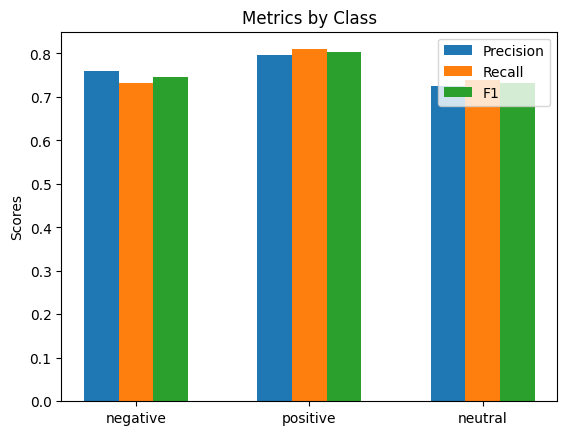

In [54]:


y_test = [label_list.index(label) for label in test['label'].values]
y_pred = preds

# Calculate F1 scores
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

# Create a bar chart
labels = label_list
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

fig, ax = plt.subplots()
width = 0.2
ind = range(len(labels))

rects1 = ax.bar(ind, precision, width, label='Precision')
rects2 = ax.bar([i + width for i in ind], recall, width, label='Recall')
rects3 = ax.bar([i + 2 * width for i in ind], f1, width, label='F1')

ax.set_ylabel('Scores')
ax.set_title('Metrics by Class')
ax.set_xticks([i + width for i in ind])
ax.set_xticklabels(labels)
ax.legend()

plt.show()


# با تشکر

